In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from nvib import VIB
import matplotlib.pyplot as plt


## Data Loader

In [36]:
data = pd.read_csv('./data/adult.csv')
data['income'].replace({'<=50K': "below50", '>50K': "above50"})
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
ordinal = OrdinalEncoder()
scaler = StandardScaler()


def data_cleanup(data):
    data.dropna()
    for col in categorical_cols:
        data[col] = data[col].str.strip()
        data.drop(data[(data[col] == "?")].index, inplace=True)
    return data

def data_inversify(synthetic_data):
    inverse_data = pd.DataFrame()
    num_cols = synthetic_data.numpy()[:,[0,2,4,10,11,12]]
    cat_cols = synthetic_data.numpy()[:,[1, 3, 5, 6,7,8,9,13,14]]
    inverse_data[categorical_cols] = ordinal.inverse_transform(cat_cols)
    inverse_data[numerical_cols] = scaler.inverse_transform(num_cols)
    return inverse_data

def data_to_matrix(data, cat_cols, num_cols):
    # Preprocess the categorical variables
    data[cat_cols] = ordinal.fit_transform(data[cat_cols])
    # min_max_scaler = MinMaxScaler()
    # data[cat_cols] = min_max_scaler.fit_transform(data[cat_cols])
    # Preprocess the numerical variables
    data[numerical_cols] = scaler.fit_transform(data[num_cols])
    # Convert DataFrame to PyTorch tensors
    tensors = torch.tensor(data.values, dtype=torch.float32)
    return tensors

data = data_cleanup(data)
data = data_to_matrix(data, categorical_cols, numerical_cols)

train_loader = DataLoader(TensorDataset(data), shuffle=True)


## Hyperparameters

In [37]:
input_dim = data.shape[1]
latent_dim = 32
beta = 1.0
learning_rate = 1e-3
num_epochs = 3
batch_size = 50

## Loss Functions

In [38]:
# Define the information bottleneck loss function
def information_bottleneck_loss(mu, log_var):
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
    return torch.mean(kl_divergence)

cross_entropy_loss = nn.CrossEntropyLoss()

In [39]:
# Instantiate the VIB model
vib = VIB(input_dim, latent_dim, beta)

# Define the optimizer
optimizer = optim.Adam(vib.parameters(), lr=learning_rate)

def train_model():
    losses = []
    # Training loop
    vib.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, log_var = vib(data[0])
            reconstruction_loss = cross_entropy_loss(recon_batch, data[0])
            bottleneck_loss = information_bottleneck_loss(mu, log_var)
            loss = reconstruction_loss * bottleneck_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss/len(train_loader.dataset))
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader.dataset):.4f}')
    return losses

losses = train_model()


Epoch 1/3, Loss: 10.3687
Epoch 2/3, Loss: 0.0007
Epoch 3/3, Loss: 0.0001


## Generate Data

In [40]:
# Generate synthetic data
def generate_synthetic_data(vib, num_samples):
    vib.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        synthetic_data = vib.decoder(z)
        synthetic_data = data_inversify(synthetic_data)
    return synthetic_data

# Generate 10 synthetic data samples
synthetic_data = generate_synthetic_data(vib, 10)

synthetic_data.to_csv("generated_synth_data.csv")

## Plot Loss 

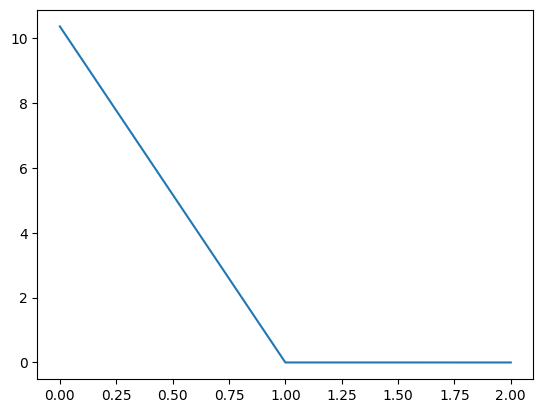

In [41]:
plt.plot(range(num_epochs), losses)